Fitting simulated data with LSTM

Trying out different parameters

- data length = 10k
    - lstm = 30
        - 300 epochs: loss = ..., MSE = ...

In [1]:
# check if gpu is used by tensorflow
# https://stackoverflow.com/a/44547144/4126114
# should show "gpu" if properly installed with init-gpu.sh from https://gist.github.com/shadiakiki1986/0c9ea999113691fb9a7ae64e3541fe29
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 841572344041848510
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 249692160
locality {
  bus_id: 1
}
incarnation: 2872876071923803359
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [2]:
# libraries (copy from p5g)

# import os
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import keras
import utils
import utils2

import pandas as pd

Using TensorFlow backend.


In [3]:
# simulated data (copy from p5g)
nb_samples = int(1e3) # FIXME # 100e3
lags = [1, 2]
X1 = pd.Series(np.random.randn(nb_samples))
X2 = pd.Series(np.random.randn(nb_samples))
# https://stackoverflow.com/a/20410720/4126114
X_model = pd.concat({'main': X1, 'lagged 1': X1.shift(lags[0]), 'lagged 2': X1.shift(lags[1]), 'new': X2}, axis=1).dropna()
                     
X_model['mult'] = X_model.apply(lambda row: row[2]*row[3], axis=1)

X_model.head()

,lagged 1,lagged 2,main,new,mult
2,-1.949395,-1.729476,0.487218,0.181607,0.088482
3,0.487218,-1.949395,0.742060,0.297281,0.220600
4,0.742060,0.487218,-0.688668,0.168208,-0.115839
5,-0.688668,0.742060,-0.609490,0.015977,-0.009738
6,-0.609490,-0.688668,1.323442,0.255350,0.337941


X (998, 5)


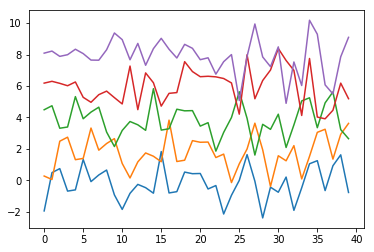

In [4]:
print('X', X_model.shape)
utils.myPlot(X_model.values[:40,:],2)

In [5]:
# Y = X_model.apply(lambda row: 0.25*row[0] + 0.25*row[1] + 0.25*row[2] + 0.25*row[3], axis=1)

Y = X_model.apply(lambda row: 0.2*row['main'] + 0.2*row['lagged 1'] + 0.2*row['lagged 2'] + 0.2*row['new'] + 0.2*row['mult'], axis=1)
Y = Y.reshape((Y.shape[0],1))

# drop columns in X_model that LSTM is supposed to figure out
del X_model['lagged 1']
del X_model['lagged 2']
del X_model['mult']

/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [6]:
X_model.head()

,main,new
2,0.487218,0.181607
3,0.742060,0.297281
4,-0.688668,0.168208
5,-0.609490,0.015977
6,1.323442,0.255350


X (998, 2) Y (998, 1)


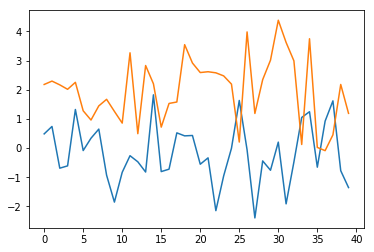

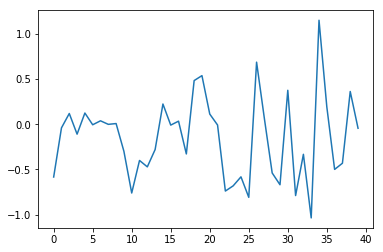

In [7]:
print('X', X_model.shape, 'Y', Y.shape)
utils.myPlot(X_model.values[:40,:],2)
utils.myPlot(Y[:40,],2)

In [8]:
# copy from utils3.py

# stride the data
from skimage.util.shape import view_as_windows # pip install scikit-image
def _load_data_strides(A, n_prev):
    out = view_as_windows(A,window_shape=(n_prev,A.shape[1]),step=1)
    out = out.reshape((out.shape[0],out.shape[2],out.shape[3])) # for some reason need to drop extra dim=1
    return out

look_back = 5
if look_back < max(lags):
    raise Exception("Not enough look back provided")
X_calib = _load_data_strides(X_model.values, look_back)
X_calib.shape

/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


(994, 5, 2)

In [9]:
Y_calib = Y[(look_back-1):]
Y_calib.shape

(994, 1)

In [10]:
# copy from g2-ml/take2/ex5-lstm/p4c4.ipynb
from keras.models import load_model
from shutil import copyfile
from datetime import datetime
model = None

from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.models import Sequential
from keras.layers.core import Dense

print("create brand new")
optimizer='adam'

model = Sequential()
in_neurons = X_model.shape[1]
lstm_dim = 30
model.add(LSTM(lstm_dim, return_sequences=False, input_shape=(None, in_neurons), activation='tanh'))#, dropout=0.25))
#enc_dim = 100
#model.add(LSTM(enc_dim, return_sequences=False, activation='tanh'))
out_neurons = 1
model.add(Dense(out_neurons, activation='linear'))

model.compile(loss="mean_squared_error", optimizer=optimizer) # nadam

model.summary()

create brand new
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                3960      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 3,991
Trainable params: 3,991
Non-trainable params: 0
_________________________________________________________________


In [24]:
epochs = 300
history = model.fit(
    x=X_calib,
    y=Y_calib,
    epochs = epochs,
    verbose = 2, #2,
    batch_size = 500, # 100
    validation_split = 0.2,
    shuffle=False
)

Train on 795 samples, validate on 199 samples
Epoch 1/300
0s - loss: 1.9634e-05 - val_loss: 6.5259e-05
Epoch 2/300
0s - loss: 1.8858e-05 - val_loss: 6.2831e-05
Epoch 3/300
0s - loss: 1.7071e-05 - val_loss: 6.1667e-05
Epoch 4/300
0s - loss: 1.6629e-05 - val_loss: 6.1925e-05
Epoch 5/300
0s - loss: 1.6969e-05 - val_loss: 6.1932e-05
Epoch 6/300
0s - loss: 1.6710e-05 - val_loss: 6.2014e-05
Epoch 7/300
0s - loss: 1.6645e-05 - val_loss: 6.3242e-05
Epoch 8/300
0s - loss: 1.7723e-05 - val_loss: 6.4563e-05
Epoch 9/300
0s - loss: 1.8753e-05 - val_loss: 6.4216e-05
Epoch 10/300
0s - loss: 1.8308e-05 - val_loss: 6.2597e-05
Epoch 11/300
0s - loss: 1.7041e-05 - val_loss: 6.1470e-05
Epoch 12/300
0s - loss: 1.6392e-05 - val_loss: 6.1282e-05
Epoch 13/300
0s - loss: 1.6401e-05 - val_loss: 6.1287e-05
Epoch 14/300
0s - loss: 1.6364e-05 - val_loss: 6.1357e-05
Epoch 15/300
0s - loss: 1.6366e-05 - val_loss: 6.1923e-05
Epoch 16/300
0s - loss: 1.6846e-05 - val_loss: 6.2774e-05
Epoch 17/300
0s - loss: 1.7529e-05 

0s - loss: 1.5082e-05 - val_loss: 5.5094e-05
Epoch 145/300
0s - loss: 1.3964e-05 - val_loss: 5.6318e-05
Epoch 146/300
0s - loss: 1.5043e-05 - val_loss: 5.9017e-05
Epoch 147/300
0s - loss: 1.7117e-05 - val_loss: 5.8282e-05
Epoch 148/300
0s - loss: 1.6162e-05 - val_loss: 5.5086e-05
Epoch 149/300
0s - loss: 1.4018e-05 - val_loss: 5.4350e-05
Epoch 150/300
0s - loss: 1.4263e-05 - val_loss: 5.5223e-05
Epoch 151/300
0s - loss: 1.4941e-05 - val_loss: 5.4775e-05
Epoch 152/300
0s - loss: 1.4038e-05 - val_loss: 5.4943e-05
Epoch 153/300
0s - loss: 1.4120e-05 - val_loss: 5.7159e-05
Epoch 154/300
0s - loss: 1.6014e-05 - val_loss: 5.8008e-05
Epoch 155/300
0s - loss: 1.6424e-05 - val_loss: 5.5815e-05
Epoch 156/300
0s - loss: 1.4602e-05 - val_loss: 5.3966e-05
Epoch 157/300
0s - loss: 1.3639e-05 - val_loss: 5.4215e-05
Epoch 158/300
0s - loss: 1.4153e-05 - val_loss: 5.4439e-05
Epoch 159/300
0s - loss: 1.4042e-05 - val_loss: 5.4208e-05
Epoch 160/300
0s - loss: 1.3600e-05 - val_loss: 5.5254e-05
Epoch 161/3

0s - loss: 1.1928e-05 - val_loss: 4.9169e-05
Epoch 289/300
0s - loss: 1.1847e-05 - val_loss: 5.0411e-05
Epoch 290/300
0s - loss: 1.2926e-05 - val_loss: 5.1396e-05
Epoch 291/300
0s - loss: 1.3596e-05 - val_loss: 5.0554e-05
Epoch 292/300
0s - loss: 1.2765e-05 - val_loss: 4.9103e-05
Epoch 293/300
0s - loss: 1.1763e-05 - val_loss: 4.8658e-05
Epoch 294/300
0s - loss: 1.1678e-05 - val_loss: 4.8770e-05
Epoch 295/300
0s - loss: 1.1795e-05 - val_loss: 4.8685e-05
Epoch 296/300
0s - loss: 1.1614e-05 - val_loss: 4.8868e-05
Epoch 297/300
0s - loss: 1.1740e-05 - val_loss: 4.9599e-05
Epoch 298/300
0s - loss: 1.2340e-05 - val_loss: 5.0125e-05
Epoch 299/300
0s - loss: 1.2683e-05 - val_loss: 4.9871e-05
Epoch 300/300
0s - loss: 1.2380e-05 - val_loss: 4.9203e-05


In [25]:
pred = model.predict(x=X_calib, verbose = 0)

In [26]:
utils.mse(Y_calib, pred)

0.010003848133563874

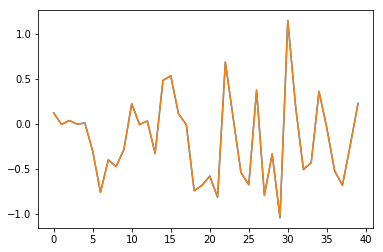

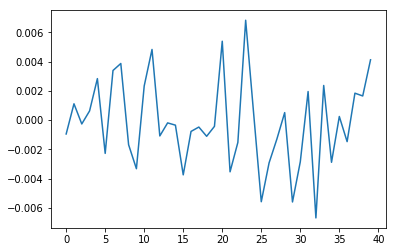

In [27]:
from matplotlib import pyplot as plt
plt.plot(pred[:40,])
plt.plot(Y_calib[:40,])
plt.show()

plt.plot(pred[:40,]-Y_calib[:40,])
plt.show()